In [3]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [33]:
mlb_batting = Table.read_table('mlb-batter-exit-velocity.csv')
mlb_batting.show(5)

id,rank,year,player,batted_ball_events,launch_angle,sweet_spot_percentage,max_ev,average_ev,fly_ball_line_drive_ev,ground_ball_ev,max_distance,average_distance,average_homerun,hard_hit_95mph+,hard_hit_percentage,hard_hit_swing_percentage,total_barrels,barrels_batted_balls_percentage,barrels_plate_appearance_percentage
1,1,2022,"Judge, Aaron",341,14.6,37.8,118.4,95.8,100.2,89.1,465,205,413,210,61.6,20.3,91,26.7,15.8
2,2,2022,"Alvarez, Yordan",304,12.1,40.1,117.4,95.5,98.2,92.7,469,193,403,186,61.2,23.7,59,19.4,12.7
3,3,2022,"Trout, Mike",234,24.7,37.2,114.4,91.7,94.9,87.7,472,218,407,120,51.3,16.5,46,19.7,11.6
4,4,2022,"Schwarber, Kyle",312,18.9,34.6,114.8,93.3,99.7,87.2,468,197,415,170,54.5,17.6,64,20.5,11.5
5,5,2022,"Stanton, Giancarlo",228,10.2,26.3,119.8,94.6,98.2,94.1,445,160,400,117,51.3,17.8,42,18.4,11.3


In [34]:
mlb_batting = mlb_batting.where('average_homerun', are.above(0))

The dataset I am using for this project (shown above) was obtained from Kaggle and has 20 different variables along with 1,983 rows. Each row is an individual MLB player's season from the years 2015 to 2022, and the variables measured are various advanced batting statistics. I am interested in this dataset because I am very interested in baseball statistics, especially the advanced ones that have come out with the introduction of Statcast into the MLB.

The main question I am looking to answer with this project is: **can you accurately predict a player's average homerun distance using their average exit velocity and average launch angle?**

First, let's take a look at some scatterplots that give us a surface-level idea of the relationship between the three most relevant variables: average homerun distance, average launch angle, and average exit velocity.

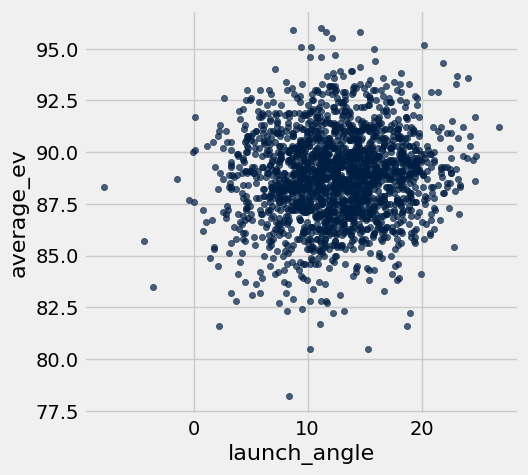

In [35]:
mlb_batting.scatter('launch_angle', 'average_ev')

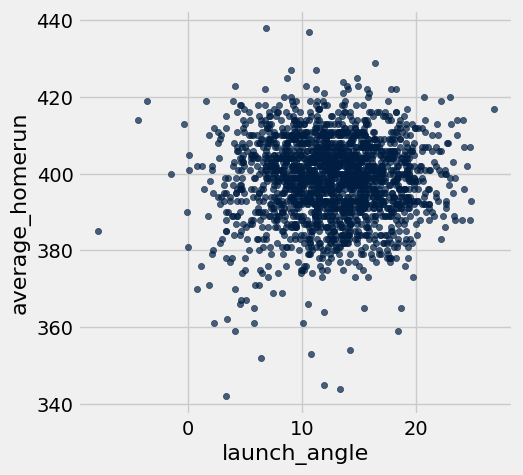

In [36]:
mlb_batting.scatter('launch_angle', 'average_homerun')

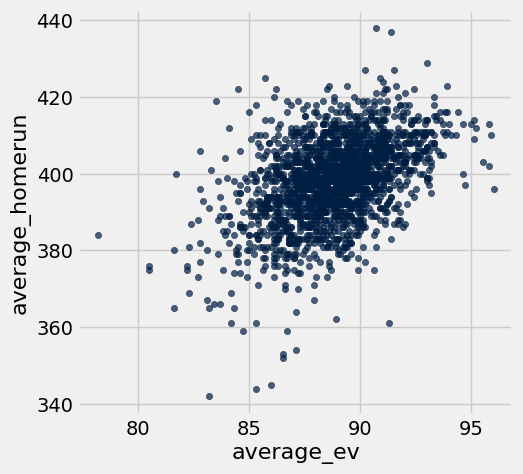

In [37]:
mlb_batting.scatter('average_ev', 'average_homerun')

As you can see from the plots, the relationships between launch angle and exit velocity as well as launch angle and homerun distance aren't clearly positive or negative. Meanwhile, there is a positive relationship that can be seen between exit velocity and homerun distance, which makes sense: the harder you hit the ball on average, the farther your homeruns will be. For now, let's look deeper into the relationship between launch angle and homerun distance.

Now, I'm going to take a sample of size 100 and use it, along with bootstrapping, to produce a confidence interval of the true correlation coefficient between average launch angle and average homerun distance.

In [38]:
my_sample = mlb_batting.sample(100, with_replacement=False)

In [40]:
def standard_units(any_numbers):
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

These two functions simplify the process of calculating the correlation coefficient.

In [41]:
correlation(my_sample, 'launch_angle', 'average_homerun')

-0.1341749829181878

In [42]:
def one_bootstrap_correlation():
    resampled_table = my_sample.sample()
    bootstrapped_correlation = correlation(resampled_table, 'launch_angle', 'average_homerun')
    return bootstrapped_correlation

The function above creates a sample of the same size, with replacement, of our original sample, and calculates the correlation coefficient of that sample. I'm now going to run that function 5000 times to create 5000 different sample correlations.

In [43]:
num_repetitions = 5000
bstrap_correlations = make_array()
for i in np.arange(num_repetitions):
    bstrap_correlations = np.append (bstrap_correlations, one_bootstrap_correlation())

Below is a histogram of those 5000 correlations and below that is the same histogram with yellow line symbolizing the 95% confidence interval.

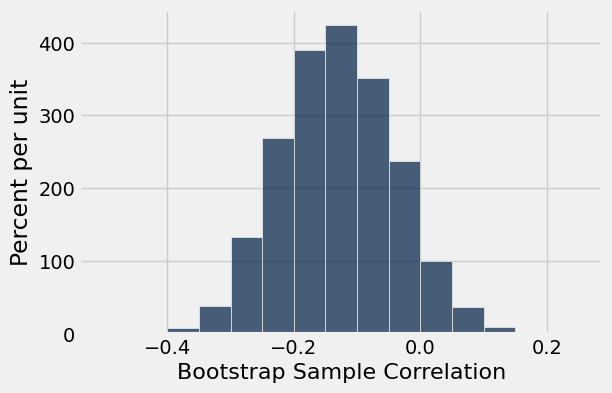

In [49]:
resampled_correlations = Table().with_column('Bootstrap Sample Correlation', bstrap_correlations)
median_bins=np.arange(-0.50, 0.30, 0.05)
resampled_correlations.hist(bins = median_bins)

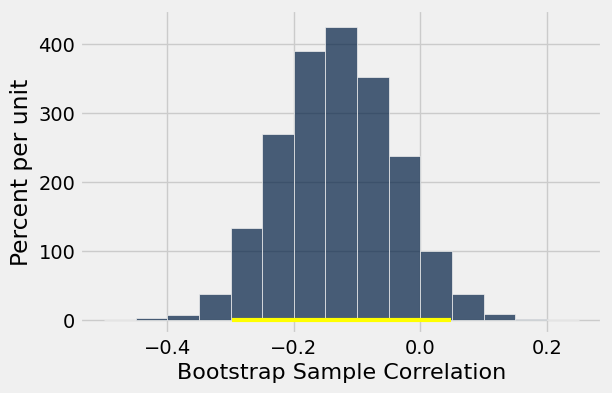

In [60]:
resampled_correlations.hist(bins = median_bins)
left = percentile(2.5, bstrap_correlations)
right = percentile(97.5, bstrap_correlations)
plots.ylim(-0.2, 4.5)
plots.plot([left, right], [0, 0], color='yellow', lw=3, zorder=1);

Because the 95% confidence interval contains 0, we cannot conclude that there is a significant positive or negative relationship between launch angle and average homerun distance. However, because I do have access to the population, I can calculate it below and compare it to the interval.

In [61]:
correlation(mlb_batting, 'launch_angle', 'average_homerun')

0.026885259878337908

In [63]:
percentile(97.5, bstrap_correlations)

0.047976151484301795

What this means in plain language is that launch angle has little to no effect on a player's average homerun distance for that season. Now, I'm going to combine it with average exit velocity to see how well it predicts a player's average homerun distance. First, we must split the dataset into training and testing, which is performed below.

In [64]:
test, train = mlb_batting.split(500)
print(train.num_rows, 'training and', test.num_rows, 'test instances.')

1474 training and 500 test instances.


The code block below tries to predict homerun distance for a row using random slope values for launch angle and exit velocity, which makes it completely useless and the value very wrong, but it serves as a starting point later.

In [65]:
def predict(slopes, row):
    return sum(slopes * np.array(row))

example_row = test.select('launch_angle', 'average_ev').row(0)
print('Predicting homerun distance for:', example_row)
example_slopes = np.random.normal(10, 1, len(example_row))
print('Using slopes:', example_slopes)
print('Result:', predict(example_slopes, example_row))

Predicting homerun distance for: Row(launch_angle=12.5, average_ev=86.0)
Using slopes: [  9.33009043  10.48759025]
Result: 1018.55889185


Below, we define how to compute the root mean squared error of our predictions, and compute it for the training rows using the random slopes from above. In the block below that, we minimize the function to find the most accurate slopes for launch angle and exit velocity to create a somewhat effective predictor.

In [66]:
train_distance = train.column('average_homerun')
train_attributes = train.select('launch_angle', 'average_ev')

def rmse(slopes, attributes, distances):
    errors = []
    for i in np.arange(len(distances)):
        predicted = predict(slopes, attributes.row(i))
        actual = distances.item(i)
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5

def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_distance)

print('RMSE of all training examples using random slopes:', rmse_train(example_slopes))

RMSE of all training examples using random slopes: 652.056720408


In [67]:
best_slopes = minimize(rmse_train, start=example_slopes, smooth=True, array=True)
print('The best slopes for the training set:')
Table(train_attributes.labels).with_row(list(best_slopes)).show()
print('RMSE of all training examples using the best slopes:', rmse_train(best_slopes))

The best slopes for the training set:


launch_angle,average_ev
-0.0695779,4.49351


RMSE of all training examples using the best slopes: 10.5887377856


Curiously, the ideal slope for launch angle to predict homerun distance is actually a slightly negative one, but we can also see that the ideal slope for exit velocity is about 4.5. Using these slopes, I will now input the test data and see how the predicted distance matches the actual distance.

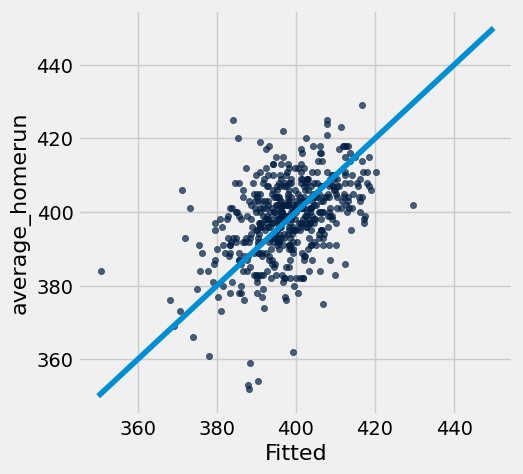

In [70]:
test_distances = test.column('average_homerun')
test_attributes = test.drop('launch_angle', 'average_ev')

def rmse_test(slopes):
    return rmse(slopes, test_attributes, test_distances)

def fit(row):
    return sum(best_slopes * np.array(row))

test.with_column('Fitted', test.select('launch_angle', 'average_ev').apply(fit)).scatter('Fitted', 'average_homerun')
plots.plot([350, 450], [350, 450]);

As the scatterplot shows, there are some predictions that were accurate, meaning they were on the blue line, but a large majority strayed from the line, meaning launch angle and average exit velocity are not a reliable way to predict average homerun distance.

**In conclusion, my analysis tells that a player's average launch angle does not have a strong relationship with their average homerun distance. Also, while exit velocity does show a relationship with homerun distance, it cannot predict distance by itself and requires other variables to make an accurate predictor.**